# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

### Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST.
- Output shape (num_students, num_timesteps, num_asts). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps) Values are in range (0, num_asts)

Accuracy:
- Raw Accuracy: For all predictions at all timesteps, we get the percentage of predictions we got correct.
- Corrected Accuracy: Since many trajectories contain fewer asts than max_traj_len, we fill the empty asts with our dummy ast token at row 0. However, predicting on end tokens is to simple of a task and might bias our results. The corrected accuracy ignores all predictions on the end token.

### Current Issues:
AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [1]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize
from constants import *

In [23]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 5e-3
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 20
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [31]:
HOC_NUM = 9
DATA_SZ = -1
# train_data, val_data, test_data, ast_id_to_row_map, row_to_ast_id_map, num_timesteps, num_asts =\
# utils.load_dataset_predict_ast(hoc_num=HOC_NUM, data_sz=DATA_SZ)

X, y, ast_maps, num_asts = utils.load_dataset_predict_ast_using_embeddings(hoc_num=HOC_NUM, data_sz=DATA_SZ)

Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!


In [33]:
num_traj, num_timesteps, embed_dim = X.shape

X_train = X[0:7*num_traj/8]
X_val =  X[7*num_traj/8: 15*num_traj/16 ]
X_test = X[15*num_traj/16:num_traj]

y_train = y[0:7*num_traj/8]
y_val =  y[7*num_traj/8: 15*num_traj/16]
y_test = y[15*num_traj/16:num_traj]

train_data = X_train, y_train
val_data = X_val, y_val
test_data = X_test, y_test
print X_train.shape
print y_train.shape
print X_val.shape
print X_test.shape
print num_timesteps
print embed_dim
print num_asts


(10783, 5, 256)
(10783, 5)
(770, 5, 256)
(771, 5, 256)
5
256
2042


In [34]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, embed_dim, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


In [35]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 6720
Ep 0 	iter 1  	loss 7.62306, train acc 0.00, train corr acc 0.00, val acc 66.68, val corr acc 37.45
Ep 0 	iter 2  	loss 7.44535, train acc 65.62, train corr acc 36.78, val acc 66.62, val corr acc 37.35
Ep 0 	iter 3  	loss 7.01289, train acc 68.12, train corr acc 38.55, val acc 66.65, val corr acc 37.40
Ep 0 	iter 4  	loss 5.99956, train acc 64.38, train corr acc 35.96, val acc 66.62, val corr acc 37.35
Ep 0 	iter 5  	loss 4.63783, train acc 63.12, train corr acc 35.16, val acc 66.73, val corr acc 37.54
Ep 0 	iter 6  	loss 3.35585, train acc 62.50, train corr acc 34.78, val acc 66.62, val corr acc 37.35
Ep 0 	iter 7  	loss 2.71144, train acc 61.88, train corr acc 34.41, val acc 66.62, val corr acc 37.35
Ep 0 	iter 8  	loss 2.06020, train acc 67.50, train corr acc 38.10, val acc 66.62, val corr acc 37.35
Ep 0 	iter 9  	loss 2.19298, train acc 66.25, train corr acc 37.21, val acc 66.62, val corr acc 37.35
Ep 0 	iter 10  	loss 2.09941, t

In [37]:
# Evaluate on test set
test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test')
test_loss, test_raw_acc, test_corrected_acc_per_timestep, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test', compute_acc_per_timestep_bool=True)
   

Testing...
Final results:
  test loss:			1.628010
  test raw accuracy:		69.86 %
  test corrected accuracy:	45.14 %
Testing...
[(88, 771), (339, 714), (373, 459), (139, 153), (19, 21)]
[0.11413748378728923, 0.47478991596638653, 0.8126361655773421, 0.9084967320261438, 0.9047619047619048]
Final results:
  test loss:			1.634869
  test raw accuracy:		69.91 %
  test corrected accuracy
  		 Timestep 0:	11.41 %
  		 Timestep 1:	47.48 %
  		 Timestep 2:	81.26 %
  		 Timestep 3:	90.85 %
  		 Timestep 4:	90.48 %


In [15]:
# Convert to AST IDs so we can look at the AST json files
traj_row_to_ast_id_map = ast_maps['traj_row_to_id']
X_test, y_test = test_data
y_test_ast_ids = utils.convert_truth_to_ast_ids(y_test, traj_row_to_ast_id_map)
pred_test_ast_ids = utils.convert_pred_to_ast_ids(pred_test, traj_row_to_ast_id_map)

print ("Truth AST IDs")
print y_test_ast_ids[10:30, :]
print("Predicted AST IDs")
print pred_test_ast_ids[10:30,:]

Truth AST IDs
[[  4.   1.   0.  -1.  -1.  -1.  -1.]
 [  6.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 17.   0.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  4.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  8.   5.   0.  -1.  -1.  -1.  -1.]
 [  8.   0.  -1.  -1.  -1.  -1.  -1.]
 [ 48.   0.  -1.  -1.  -1.  -1.  -1.]
 [  4.   1.   0.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [ 23.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 44.   0.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  4.  22.   0.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 13.  -1.  -1.  -1.  -1.  -1.  -1.]]
Predicted AST IDs
[[  2.   0.   0.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [  5.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.  -1.  -1. 

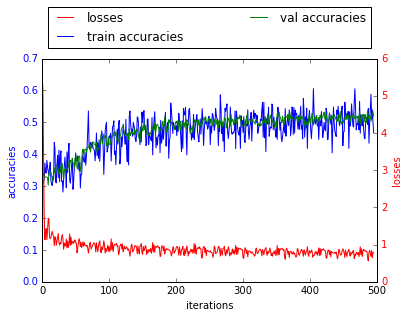

In [16]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = train_data[0].shape[0]
visualize.plot_loss_acc('hoc' + str(HOC_NUM) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')

In [10]:
train_data, val_data, test_data, ast_id_to_row_map, row_to_ast_id_map, num_timesteps, num_asts = utils.load_dataset_predict_ast(hoc_num=HOC_NUM, data_sz=DATA_SZ)

Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
X_train shape (10783, 5, 2042)
y_train shape (10783, 5)
X_val shape (770, 5, 2042)
X_test shape (771, 5, 2042)
num_timesteps 5
Inputs and targets done!


In [12]:
num_train, num_timesteps, num_asts = train_data[0].shape

In [14]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


In [16]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 6720
Ep 0 	iter 1  	loss 1.46117, train acc 74.38, train corr acc 49.38, val acc 69.12, val corr acc 42.89
Ep 0 	iter 2  	loss 1.49945, train acc 71.88, train corr acc 45.12, val acc 69.01, val corr acc 42.70
Ep 0 	iter 3  	loss 1.35752, train acc 73.12, train corr acc 43.42, val acc 68.91, val corr acc 42.51
Ep 0 	iter 4  	loss 1.78713, train acc 67.50, train corr acc 42.86, val acc 68.42, val corr acc 41.59
Ep 0 	iter 5  	loss 1.59701, train acc 66.25, train corr acc 43.75, val acc 68.26, val corr acc 41.31
Ep 0 	iter 6  	loss 1.84100, train acc 61.25, train corr acc 33.33, val acc 68.36, val corr acc 41.50


KeyboardInterrupt: 